In [1]:
from util.MicFileTool import MicFile
import util.Simulation as Gsim
import util.RotRep as Rot
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import h5py
from scipy.signal import convolve2d

In [2]:
from config import Config
Cfg = Config('ConfigFiles/RealG15.yml')

# Read Grain Map from the LBFS File

In [3]:
a=MicFile("AuxData/Ti7_WithHRM_2ndLoad_z1_.mic.LBFS")

-0.556875 -0.00974279 0 2 7 1 281.746 88.7135 78.1765 0.145161 0.885753 0.14876 0 1 1 1 0 0 0

<class 'str'>
sw is 0.72 

shape of snp is (32855, 19)


In [4]:
grid_x,grid_y=np.meshgrid(np.arange(-0.5,0.2,0.002),np.arange(-0.4,0.4,0.002))
grid_c = griddata(a.snp[:,0:2],a.snp[:,9],(grid_x,grid_y),method='nearest')
grid_e1 = griddata(a.snp[:,0:2],a.snp[:,6],(grid_x,grid_y),method='nearest')
grid_e2 = griddata(a.snp[:,0:2],a.snp[:,7],(grid_x,grid_y),method='nearest')
grid_e3 = griddata(a.snp[:,0:2],a.snp[:,8],(grid_x,grid_y),method='nearest')

In [5]:
GrainDict={}
GrainDict[2]=(96.6718, 83.8559, 292.454)
GrainDict[8]=(153.18, 83.0631, 205.721)
GrainDict[13]=(120.784,   80.9295,  246.202)
GrainDict[14]=(307.363,71.8926,74.2928)
GrainDict[15]=(298.089, 65.4218, 42.9553)

GrainDict[23]=(137.852, 77.3726, 206.271)
GrainDict[24]=(341.519, 79.2855, 7.2755)
GrainDict[25]=(328.93, 88.8624, 11.7176)

GrainDict[45]=(117.498,   86.6945,  214.956)
GrainDict[46]=(147.248,   81.8513,  217.515)
GrainDict[50]=(331.545, 72.4743, 52.0357)
GrainDict[55]=(97.9141, 90.0041, 259.313)

In [6]:
GrainIDMap=np.zeros(grid_c.shape,dtype=int)
for grainID in GrainDict:
    (e1,e2,e3)=GrainDict[grainID]
    tmp = grid_c > 0.3
    tmp*=np.absolute(grid_e1 - e1)<1
    tmp*=np.absolute(grid_e2 - e2)<1
    tmp*=np.absolute(grid_e3 - e3)<1
    GrainIDMap += grainID * tmp

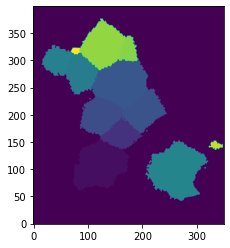

In [7]:
plt.imshow(GrainIDMap,origin='lower')
plt.show()

In [8]:

with h5py.File(Cfg.micFile,'w') as f:
    ds=f.create_dataset("origin", data = np.array([-0.5,-0.4]))
    ds.attrs[u'units'] = u'mm'
    ds=f.create_dataset("stepSize", data = np.array([0.002,0.002]))
    ds.attrs[u'units'] = u'mm'
    f.create_dataset("Xcoordinate", data = grid_x)
    f.create_dataset("Ycoordinate", data = grid_y)
    f.create_dataset("Confidence", data = grid_c)
    f.create_dataset("Ph1", data = grid_e1)
    f.create_dataset("Psi", data = grid_e2)
    f.create_dataset("Ph2", data = grid_e3)
    f.create_dataset("GrainID", data = GrainIDMap)

# Create HDF5 File for the Bragg Peaks of One Grain

In [9]:
energy = Cfg.energy
etalimit=Cfg.etalimit/180.0*np.pi

########################
# Detector parameters (after my recalibration of 2nd) 
########################

Det=Gsim.Detector(psizeJ=Cfg.pixelSize/1000.0,psizeK=Cfg.pixelSize/1000.0)
Det.Move(Cfg.JCenter,Cfg.KCenter,np.array([Cfg.Ldistance,0,0]),Rot.EulerZXZ2Mat(np.array(Cfg.tilt)/180.0*np.pi))


#########################
# Default Ti7 LP
#########################
Ti7=Gsim.CrystalStr()
Ti7.PrimA = Cfg.lattice[0] * np.array([1, 0, 0])
Ti7.PrimB = Cfg.lattice[1] * np.array([np.cos(np.pi * 2 / 3), np.sin(np.pi * 2 / 3), 0])
Ti7.PrimC = Cfg.lattice[2] * np.array([0, 0, 1])
Atoms = Cfg.atoms
for ii in range(len(Atoms)):
    Ti7.addAtom(list(map(eval, Atoms[ii][0:3])), Atoms[ii][3])

Ti7.getRecipVec()
Ti7.getGs(Cfg.maxQ)

In [10]:
# Extract the window around the peak on a single omega frame

def fetch(ii,pks,fn,offset=0,dx=150,dy=80,verbo=False,bGetLimit=False):
    omegid=int((180-pks[ii,2])*20)+offset
    if omegid<0:
        omegid+=3600
    if omegid>=3600:
        omegid-=3600
    I=plt.imread(fn+'{0:06d}.tif'.format(omegid))
    x1=int((2047-pks[ii,0])-dx)
    y1=int(pks[ii,1]-dy)
    if verbo:
        print 'y=',pks[ii,1]
        print 'x=',pks[ii,0]
    x1=max(0,x1)
    y1=max(0,y1)
    x2=x1+2*dx
    y2=y1+2*dy
    x2=min(x2,2048)
    y2=min(y2,2048)
    if bGetLimit:
        return I[y1:y2,x1:x2],(x1,x2,y1,y2,omegid)
    return I[y1:y2,x1:x2]

SyntaxError: Missing parentheses in call to 'print'. Did you mean print(...)? (2141972625.py, line 13)

In [ ]:
gid=Cfg.grainID
strName='g{:02d}'.format(gid)

pos=np.array((np.mean(grid_x[np.where(GrainIDMap==gid)]),np.mean(grid_y[np.where(GrainIDMap==gid)]),0))
orien=Rot.EulerZXZ2Mat(np.array(GrainDict[gid])/180.0*np.pi)
Ps,Gs,Info=Gsim.GetProjectedVertex(Det,Ti7,orien,etalimit,pos,getPeaksInfo=True,
                                           omegaL=0,omegaU=180,energy=energy)
print(len(Ps))

In [ ]:
fn='TiffFiles/Ti7_WithHRM_Under2ndLoad__'
pks=Ps
for ii in range(len(pks)):
    allpks=[]
    alllims=[]
    totoffset=0
    f,axis=plt.subplots(9,5)
    i=0
    j=0
    for offset in range(totoffset-22,totoffset+23):
        Im,limits=fetch(ii,pks,fn,offset,dx=150,dy=80,more=True)
        
        if i==9:
            j+=1
            i=0
        axis[i,j].imshow(Im,vmin=0,vmax=30)
        i+=1
        
        allpks.append(Im)
        alllims.append(limits)
        
    f.subplots_adjust(wspace=0,hspace=0)
    f.savefig(strName+'PeakImg/{0:d}.png'.format(ii),dpi=200,bbox_inches='tight')
    plt.close(f)
    allpks=np.array(allpks)
    alllims=np.array(alllims)
    np.save(strName+'RawImgData/Im{0:d}'.format(ii),allpks)
    np.save(strName+'RawImgData/limit{0:d}'.format(ii),alllims)

In [ ]:
# manually label the bad images in the folder of PeakImg
# "bad" means extremely low signal to noise ratio or can't find the peak at all
badIdx=[0,2]

In [ ]:
# apply some filters to remove the noise


Nfile=len(Ps)

Im=[]
flucThresh=4

for ii in range(Nfile):
    Im.append(np.load(strName+'RawImgData/Im{:d}.npy'.format(ii)))
    Im[ii]=Im[ii]-np.median(Im[ii],axis=0) #substract the median
    mask=Im[ii]>flucThresh
    Im[ii]=mask*Im[ii] #make all pixel that below the fluctuation to be zero 


mykernel=np.array([[1,1,1],[1,-1,1],[1,1,1]])
# remove hot spot (whose value is higher than the sum of 8 neighbors)
for ii in range(Nfile):
    for jj in range(45):
        mask=convolve2d(Im[ii][jj],mykernel,mode='same')>0
        Im[ii][jj]*=mask
        

mykernel2=np.array([[1,2,1],[2,4,2],[1,2,1]])/16.0
# Smoothing
for ii in range(Nfile):
    for jj in range(45):
        Im[ii][jj]=convolve2d(Im[ii][jj],mykernel2,mode='same')

for ii in range(Nfile):
    np.save(strName+'FilteredImgData/Im{:d}'.format(ii),Im[ii].astype('uint16'))

In [ ]:
goodidx = np.delete(np.arange(len(Ps)), badIdx)

imgN = len(goodidx)
peakMap = np.zeros((160,300,45*imgN),dtype=np.uint16)
LimH = np.empty((imgN,5),dtype=np.int32)
Gs_good = Gs[goodidx]
whichOmega = np.empty(imgN,dtype=np.int32)


avg_distortion = np.eye(3)
MaxInt = np.empty(imgN,dtype=np.float32)

for ii in range(imgN):
    limit=np.load(strName+'RawImgData/limit{0:d}.npy'.format(goodidx[ii]))
    img = np.load(strName+'FilteredImgData/Im{0:d}.npy'.format(goodidx[ii]))
    peakMap[:img.shape[1],:img.shape[2],ii * 45:(ii + 1) * 45] = np.moveaxis(img,0,-1)
    LimH[ii,:]=limit[0]
    MaxInt[ii]=np.max(img)
    if Info[goodidx[ii]]['WhichOmega']=='b':
        whichOmega[ii] = 2
    else:
        whichOmega[ii] = 1



with h5py.File(Cfg.peakFile, 'w') as f:
    f.create_dataset("limits", data=LimH)
    f.create_dataset("Gs", data=Gs_good)
    f.create_dataset("whichOmega", data=whichOmega)
    f.create_dataset("Pos", data=pos)
    f.create_dataset("OrienM", data=orien)
    f.create_dataset("avg_distortion", data=avg_distortion)
    f.create_dataset("MaxInt", data=MaxInt)

    grp = f.create_group('Imgs')
    for ii in range(imgN):
        grp.create_dataset('Im{0:d}'.format(ii), data=peakMap[:,:,ii * 45:(ii + 1) * 45])